## Machine Learning Models for Options Trading
In this notebook, we present a solution for the project on options trading using a variety of machine learning techniques. The notebook includes both classification and regression models to address problem statements related to options analysis. Specifically, we incorporate K-Nearest Neighbors (KNN) and Logistic Regression for classification tasks, and Linear Regression for regression tasks. These additions aim to broaden the scope of the analysis and evaluate their effectiveness compared to existing approaches.
The notebook is structured as follows:
1. [Import the Data](#import-the-data)
2. [Features Related to the Underlying Asset](#features-related-to-the-underlying-asset)
3. [Features Related to the Options Greeks](#features-related-to-the-options-greeks)
4. [Features Related to the Options Contract](#features-related-to-the-options-contract)
5. [Strategy Calculations](#strategy-calculations)
6. [Scale the Data](#scale-the-data)
7. [Logistic Regression](#logistic-regression)
8. [K-Nearest Neighbors (KNN) Classification](#k-nearest-neighbors-knn-classification)
9. [Linear Regression](#linear-regression)
10. [Performance Analysis of Logistic Regression](#performance-analysis-of-logistic-regression)
11. [Performance Analysis of K-Nearest Neighbors](#performance-analysis-of-k-nearest-neighbors)
12. [Performance Analysis of Linear Regression](#performance-analysis-of-linear-regression)
13. [Conclusion](#conclusion)

In [112]:
# For data manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For warnings supression
import warnings 
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix,roc_curve, roc_auc_score, recall_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (8, 4)

## <a id='read'></a>
## Import the Data

Import the files spx_eom_options_2010_2022.bz2 as options_data and sp500_index_2010_2022.csv as underlying_data using the read_pickle and read_csv method of pandas.

In [23]:
# Import EOM SPX options data from 2010-2022
options_data = pd.read_pickle(r'../ML_I/spx_eom_expiry_options_2010_2022')

# Set index for the data
options_data.index.name = 'index'

# # Import the underlying data i.e. S&P 500 index data
underlying_data = pd.read_csv(
    'sp500_index_2010_2022.csv', index_col='Date')[['Open', 'High', 'Low', 'Close']]

# # Convert index dtype to datetime
underlying_data.index = pd.to_datetime(underlying_data.index)

In the underlying_data, filter the days for which the options data is available in the dataframe options_data and create the atm_strike_price column to store the strike price. 

The atm strike price is the strike price of the contract that is closest to the close price of the underlying. So, to find the atm_strike_price values, find the strike price of the contract which has the minimum ' [STRIKE_DISTANCE_PCT]' value.

In [24]:
# Selecting underlying data for index range of options data
underlying_data = underlying_data[underlying_data.index.isin(
    options_data.index)].dropna()

# Create the 'atm_strike_price' column with NaN values
underlying_data['atm_strike_price'] = np.nan

# Calculate atm strike price
for i in range(0, len(underlying_data)):
    trading_day_data = options_data.loc[underlying_data.index[i]]
    underlying_data['atm_strike_price'][i] = trading_day_data[trading_day_data[' [STRIKE_DISTANCE_PCT]']
                                                              == trading_day_data[' [STRIKE_DISTANCE_PCT]'].min()][' [STRIKE]'][0]

The underlying_data dataframe has OHLC values of the S&P 500 index along with the atm strike price. The options_data dataframe has option chain data of call and put options of the S&P 500 index. Merge these two dataframes and create a master data frame that has the trading day as an index and OHLC values of the underlying, atm strike price and option chain data of call and put options of the S&P 500 index. This dataframe is named underlying_data.

In [25]:
# Change the data type of the column ' [QUOTE_DATE]' from 'object' to 'datetime'
options_data[' [QUOTE_DATE]'] = pd.to_datetime(options_data.index)

# Merge the dataframes 'underlying_data' and 'options_data'
underlying_data = pd.merge(underlying_data, options_data, left_on=[
                           'Date', 'atm_strike_price'], right_on=[' [QUOTE_DATE]', ' [STRIKE]'])

# Improving the column names by changing them to lower case and adding 'call' and 'put' to the names of the columns
underlying_data.columns = underlying_data.columns.str.replace('[', '').str.replace(
    ']', '').str.strip().str.lower().str.replace('c_', 'call_').str.replace('p_', 'put_')

# Removing rows where either the call and put strike prices are 0
underlying_data = underlying_data[(
    underlying_data.call_last != 0) & (underlying_data.put_last != 0)]
underlying_data.head()

,open,high,low,close,atm_strike_price,strike,strike_distance_pct,call_last,underlying_last,put_last,...,call_theta,call_rho,call_iv,put_delta,put_gamma,put_vega,put_theta,put_rho,put_iv,quote_date
1,1117.010010,1123.459961,1116.510010,1118.310059,1125.0,1125.0,0.006,16.15,1117.98,23.2,...,-0.30847,0.37731,0.156100,-0.55790,0.00780,1.26269,-0.36309,-0.53265,0.156850,2010-03-02
2,1119.359985,1125.640015,1116.579956,1118.790039,1125.0,1125.0,0.006,19.50,1118.49,23.2,...,-0.32176,0.37714,0.152320,-0.54783,0.00797,1.24798,-0.35476,-0.50447,0.157850,2010-03-03
3,1119.119995,1123.729980,1116.660034,1122.969971,1125.0,1125.0,0.002,19.50,1122.68,22.0,...,-0.33080,0.38313,0.158060,-0.52029,0.00810,1.23698,-0.37690,-0.46392,0.158500,2010-03-04
7,1140.219971,1148.260010,1140.089966,1145.609985,1150.0,1150.0,0.004,13.10,1145.36,20.0,...,-0.37266,0.29926,0.149510,-0.54093,0.00929,1.11512,-0.40092,-0.38429,0.151130,2010-03-10
8,1143.959961,1150.239990,1138.989990,1150.239990,1150.0,1150.0,0.000,13.30,1149.96,17.4,...,-0.38001,0.32599,0.143280,-0.49280,0.00942,1.09985,-0.41159,-0.32547,0.155080,2010-03-11


The input features for the ML model to predict the options strategy to deploy has two types of features. 
1. Features related to the underlying asset.
2. Features related to the options market.

<a id='features_underlying'></a>
## Features Related to the Underlying Asset

Historical returns of the underlying asset across multiple periods, technical indicators of momentum and volatility are used as input features.

1. **Historical returns:** 1,5,10,22,44 and 88 days returns of the underlying asset.
2. **Momentum:** Relative Strength Index (RSI) of the close price of the underlying asset.
3. **Volatility:** Average True Range(ATR), upper, lower and middle Bollinger Bands of the underlying asset.


In [29]:
underlying_data

,open,high,low,close,atm_strike_price,strike,strike_distance_pct,call_last,underlying_last,put_last,...,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_rsi,f_natr,f_norm_upper,f_norm_lower,f_norm_middle
1,1117.010010,1123.459961,1116.510010,1118.310059,1125.0,1125.0,0.006,16.15,1117.98,23.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1119.359985,1125.640015,1116.579956,1118.790039,1125.0,1125.0,0.006,19.50,1118.49,23.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1119.119995,1123.729980,1116.660034,1122.969971,1125.0,1125.0,0.002,19.50,1122.68,22.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1140.219971,1148.260010,1140.089966,1145.609985,1150.0,1150.0,0.004,13.10,1145.36,20.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1143.959961,1150.239990,1138.989990,1150.239990,1150.0,1150.0,0.000,13.30,1149.96,17.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.007502,0.959364,0.983433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590,3727.139893,3727.139893,3647.469971,3693.229980,3695.0,3695.0,0.000,57.80,3695.49,66.68,...,-0.046497,-0.091984,-0.105480,-0.067750,-0.078538,33.849254,78.840681,1.068073,0.989418,1.028746
2591,3682.719971,3715.669922,3644.760010,3655.040039,3655.0,3655.0,0.000,64.90,3656.13,52.00,...,-0.062784,-0.110785,-0.117304,-0.078602,-0.106096,32.833806,79.919957,1.064880,0.987313,1.026097
2592,3686.439941,3717.530029,3623.290039,3647.290039,3650.0,3650.0,0.000,48.00,3648.49,47.66,...,-0.054109,-0.072571,-0.131416,-0.069818,-0.070441,25.306635,80.804252,1.047776,0.985896,1.016836
2593,3651.939941,3736.739990,3640.610107,3719.040039,3715.0,3715.0,0.001,46.50,3717.69,31.55,...,-0.018705,-0.057519,-0.083452,-0.075696,-0.046593,30.028111,82.978533,1.015476,0.971337,0.993406


In [ ]:
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_atr(data, period=14):
    high_low = data['high'] - data['low']
    high_close = np.abs(data['high'] - data['close'].shift())
    low_close = np.abs(data['low'] - data['close'].shift())
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_bollinger_bands(data, period=20):
    middle_band = data['close'].rolling(window=period).mean()
    std_dev = data['close'].rolling(window=period).std()
    
    upper_band = middle_band + (2 * std_dev)
    lower_band = middle_band - (2 * std_dev)
    
    return upper_band, middle_band, lower_band

In [31]:
# Historical returns
intervals = [1, 5, 10, 22, 44, 88]

# Past returns of multiple time periods
for t in intervals:
    underlying_data[f'f_ret_{t}'] = underlying_data.close.pct_change(t)

# RSI of the underlying
underlying_data['f_rsi'] = calculate_rsi(underlying_data.close)

# ATR of the underlying
underlying_data['f_natr'] = calculate_atr(
    underlying_data)

# Bollinger bands of the underlying
upper, middle, lower = calculate_bollinger_bands(underlying_data)
underlying_data['f_norm_upper'] = upper/underlying_data.close
underlying_data['f_norm_lower'] = lower/underlying_data.close
underlying_data['f_norm_middle'] = middle/underlying_data.close

# Features related to the underlying asset
underlying_data.filter(like='f_').dropna().head()

,f_ret_1,f_ret_5,f_ret_10,f_ret_22,f_ret_44,f_ret_88,f_rsi,f_natr,f_norm_upper,f_norm_lower,f_norm_middle
97,-0.006049,-0.010488,0.029061,0.045139,0.168393,0.159240,61.970062,16.192862,1.031909,0.936466,0.984187
98,-0.011200,-0.030223,0.019072,0.033383,0.142588,0.145765,57.412873,18.370013,1.043068,0.951241,0.997155
99,-0.019495,-0.047833,-0.000604,0.012315,0.121113,0.119246,49.829466,20.217861,1.063206,0.971870,1.017538
100,0.013398,-0.016516,-0.026535,0.031160,0.132125,0.111827,53.631971,21.526428,1.048492,0.962018,1.005255
101,0.004310,-0.019221,-0.038889,0.029239,0.137419,0.112124,54.547995,22.317147,1.043476,0.960917,1.002197


In [76]:
underlying_data['ema_12'] = underlying_data['close'].ewm(span=12, adjust=False).mean()
underlying_data['ema_26'] = underlying_data['close'].ewm(span=26, adjust=False).mean()
underlying_data['MACD'] = underlying_data['ema_12'] - underlying_data['ema_26']
underlying_data['Signal_Line'] = underlying_data['MACD'].ewm(span=9, adjust=False).mean()

# Feature 2: On-Balance Volume (OBV)
underlying_data['Rolling_Volatility'] = underlying_data['close'].rolling(window=14).std()

underlying_data['daily_return'] = underlying_data['close'].pct_change()
underlying_data['Skewness'] = underlying_data['daily_return'].rolling(window=14).skew()
underlying_data['Kurtosis'] = underlying_data['daily_return'].rolling(window=14).kurt()

underlying_data = underlying_data.dropna()

<a id='greeks'></a>
## Features Related to the Options Greeks

Features related to options greeks such as delta, gamma, vega, theta, and rho are used to measure different factors that might affect the price of an options contract. These features are already present in the dataframe underlying_data.

In [32]:
# Features related to options greeks
underlying_data[['call_delta', 'call_gamma', 'call_vega', 'call_theta', 'call_rho',
                 'put_delta', 'put_gamma', 'put_vega', 'put_theta', 'put_rho', ]].head()

,call_delta,call_gamma,call_vega,call_theta,call_rho,put_delta,put_gamma,put_vega,put_theta,put_rho
1,0.44153,0.00792,1.26223,-0.30847,0.37731,-0.55790,0.00780,1.26269,-0.36309,-0.53265
2,0.44955,0.00824,1.24661,-0.32176,0.37714,-0.54783,0.00797,1.24798,-0.35476,-0.50447
3,0.47999,0.00819,1.23668,-0.33080,0.38313,-0.52029,0.00810,1.23698,-0.37690,-0.46392
7,0.45857,0.00943,1.11520,-0.37266,0.29926,-0.54093,0.00929,1.11512,-0.40092,-0.38429
8,0.50640,0.01009,1.10025,-0.38001,0.32599,-0.49280,0.00942,1.09985,-0.41159,-0.32547


 <a id='contract'></a>
## Features Related to the Options Contract
In addition to the options greeks, other metrics of options contracts such as days to expiration, last traded price of the at the money call and put, implied volatility of the at the money call and put, last traded price of the underlying asset and strike price of at the money contract are used as input features.



In [33]:
# Print the features related to the options contract
underlying_data[['dte', 'call_last', 'put_last',
                 'close', 'call_iv', 'put_iv',  'atm_strike_price']].head()

,dte,call_last,put_last,close,call_iv,put_iv,atm_strike_price
1,28.96,16.15,23.2,1118.310059,0.156100,0.156850,1125.0
2,27.96,19.50,23.2,1118.790039,0.152320,0.157850,1125.0
3,26.96,19.50,22.0,1122.969971,0.158060,0.158500,1125.0
7,20.96,13.10,20.0,1145.609985,0.149510,0.151130,1150.0
8,19.96,13.30,17.4,1150.239990,0.143280,0.155080,1150.0


Create a final features list combining all three types of features and store it in the list features.

In [78]:
# Final list of features
features = ['call_last', 'put_last', 'close', 'atm_strike_price',
            'dte', 'call_delta', 'call_gamma', 'call_vega',
            'call_theta', 'call_rho', 'call_iv', 'put_delta', 'put_gamma',
            'put_vega', 'put_theta', 'put_rho', 'put_iv', 'f_ret_1', 'f_ret_5',
            'f_ret_10', 'f_ret_22', 'f_ret_44', 'f_ret_88', 'f_natr', 'f_rsi',
            'f_norm_upper', 'f_norm_lower', 'f_norm_middle', 'ema_12',
            'ema_26', 'MACD', 'Signal_Line', 'Rolling_Volatility', 'daily_return',
            'Skewness', 'Kurtosis']

# Values of input features
underlying_data[features].dropna().head()

,call_last,put_last,close,atm_strike_price,dte,call_delta,call_gamma,call_vega,call_theta,call_rho,...,f_norm_lower,f_norm_middle,ema_12,ema_26,MACD,Signal_Line,Rolling_Volatility,daily_return,Skewness,Kurtosis
111,8.50,7.70,1337.380005,1335.0,8.0,0.49932,0.01841,0.82040,-0.38236,0.12844,...,0.944601,0.974804,1313.077987,1304.224580,8.853407,3.840204,23.103351,0.008712,-0.950291,0.894960
112,7.20,7.50,1335.250000,1335.0,4.0,0.49037,0.02185,0.62250,-0.70337,0.08344,...,0.945297,0.977300,1316.489066,1306.522760,9.966307,5.065425,23.941505,-0.001593,-1.163270,2.451439
113,7.65,5.75,1347.239990,1345.0,3.0,0.50045,0.02191,0.54571,-0.73294,0.05387,...,0.935242,0.969546,1321.219978,1309.538851,11.681127,6.388565,21.868206,0.008980,0.044618,-0.993017
114,5.10,4.20,1355.660034,1355.0,2.0,0.50579,0.03278,0.48952,-0.83289,0.05230,...,0.927246,0.964839,1326.518448,1312.955235,13.563213,7.823495,21.765438,0.006250,0.056640,-0.567550
115,3.25,3.10,1360.479980,1360.0,1.0,0.44736,0.04709,0.37165,-0.68887,0.01989,...,0.922916,0.963823,1331.743299,1316.475586,15.267713,9.312338,21.467655,0.003555,0.090700,-0.576740


<a id='calculations'></a>
## Strategy Calculations

The cost of the straddle is the sum of the put premium and call premium. Create the column cost_straddle in the underlying_data dataframe. In this exercise, we are testing a short straddle strategy where a straddle is shorted on the trading day and bought back after 3 days.

Create the column straddle_returns in the underlying_data dataframe. 

The short straddle strategy is profitable when the cost of straddle declines during the holding period of three days. Hence, store 1 as straddle_returns when the cost of straddle on trading day is greater than cost of straddle after three days. Similarly, store 0 as straddle_returns when the cost of straddle on trading day is less than cost of straddle after three days.

In [79]:
# Create the column 'cost_straddle'
underlying_data['cost_straddle'] = underlying_data['put_last']+underlying_data['call_last']

# Create the column 'straddle_returns'
underlying_data['straddle_returns'] = np.where(
     underlying_data.cost_straddle > underlying_data.cost_straddle.shift(-3), 1, 0)

In [81]:
# Create list 'model_columns' with input features, target variable 
model_columns = ['call_last', 'dte', 'call_delta', 'call_gamma', 'call_vega',
       'call_theta', 'call_rho', 'call_iv', 'put_delta', 'put_gamma',
       'put_vega', 'put_theta', 'put_rho', 'put_iv', 'f_ret_1', 'f_ret_5',
       'f_ret_10', 'f_ret_22', 'f_ret_44', 'f_ret_88', 'f_natr', 'f_rsi',
       'f_norm_upper', 'f_norm_lower', 'f_norm_middle','straddle_returns',
            'ema_26', 'MACD', 'Signal_Line', 'Rolling_Volatility', 'daily_return',
            'Skewness', 'Kurtosis']

# Create the dataframe 'model_data' by selecting 'model_columns' from 'underlying_data'
model_data = underlying_data[model_columns]
model_data.call_iv = pd.to_numeric(model_data.call_iv, errors='coerce')
model_data.put_iv = pd.to_numeric(model_data.put_iv, errors='coerce')
model_data=model_data.dropna()

Create dependent variable(y) and independent variables(X) from underlying_data

In [82]:
# Store the data of input variables in X
X = model_data.drop(['straddle_returns'], axis=1)

# Store the target variable in y
y = model_data['straddle_returns'].shift(-1)

Create train, test datasets with 80% and 20% data respectively

In [83]:
# Use test_size as 20%
test_size = int(0.2*(len(X)))

# Create train and test sets for dependent and independent variables
X_train = X[:-test_size]
X_test = X[-test_size:-1]
y_train = y[:-test_size]
y_test = y[-test_size:-1]
y_test = [int(x) for x in y_test]
# Print 'y_test'
y_test[:5]

[1, 1, 0, 0, 1]

The target variable of '0' indicates that the short straddle is not profitable while '1' indicates that the short straddle is  profitable.

<a id='scaling'></a>
## Scale the Data

Scale the train and test data using StandardScaler() method of sklearn.preprocessing

In [84]:
# Create the scaler object
scaler = StandardScaler()

# Scale the train data and store in 'X_train_scaled'
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

# Scale the test data and store in 'X_test_scaled'
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# Save the scaled independent variables in 'X_scaled'
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
round(X_scaled.head(),2)

,call_last,dte,call_delta,call_gamma,call_vega,call_theta,call_rho,call_iv,put_delta,put_gamma,...,f_norm_upper,f_norm_lower,f_norm_middle,ema_26,MACD,Signal_Line,Rolling_Volatility,daily_return,Skewness,Kurtosis
111,-0.81,-0.72,-0.05,0.10,-1.25,0.66,-1.13,-0.26,-0.33,0.13,...,-0.51,-0.62,-0.76,-1.83,0.05,-0.14,-0.27,0.68,-0.99,0.00
112,-0.88,-1.18,-0.25,0.20,-1.52,0.29,-1.29,-0.20,-0.17,0.13,...,-0.42,-0.59,-0.67,-1.83,0.09,-0.09,-0.24,-0.18,-1.21,0.65
113,-0.86,-1.30,-0.03,0.20,-1.62,0.26,-1.40,0.15,-0.51,0.28,...,-0.54,-0.92,-0.95,-1.82,0.16,-0.04,-0.31,0.70,0.07,-0.78
114,-0.99,-1.41,0.09,0.49,-1.69,0.15,-1.40,-0.39,0.03,0.32,...,-0.57,-1.17,-1.12,-1.81,0.22,0.02,-0.31,0.48,0.08,-0.61
115,-1.08,-1.53,-1.22,0.87,-1.85,0.31,-1.52,-0.39,-3.82,1.35,...,-0.52,-1.31,-1.16,-1.81,0.29,0.07,-0.33,0.25,0.12,-0.61


Let's check the distribution of target variables '0' and '1' in the training data

In [85]:
weight_class_0 = int(100*(len(y_train)-y_train.values.sum())/y_train.values.sum())
weight_class_1 = 100-weight_class_0

print (f' {weight_class_0} % of data has 0 as training labels')
print (f' {weight_class_1} % of data has 1 as training labels')

 33 % of data has 0 as training labels
 67 % of data has 1 as training labels


As you can see, there is a class imbalance whereas class_1 has higher occurrences than class_0. So,to deal with the class imbalance problem, we can pass the weights of each class to the logistic regression model as class_weight parameter. This makes sure that the penality is higher for errors in minority class.

In [86]:
weights = {0:weight_class_0, 1:weight_class_1}
weights

{0: 33, 1: 67}

<a id='logistic_regression'></a>
## Logistic Regression

Define the logistic regression with an input parameter of class_weight and save it in the variable model

In [87]:
# Define the model
model = LogisticRegression(class_weight=weights)

Fit the model on scaled training data 

In [88]:
# Fit the model 
model.fit(X_train_scaled,y_train)

LogisticRegression(class_weight={0: 33, 1: 67})

Predict the target variable by passing scaled test data to the model and save the predicted glasses in y_pred

In [89]:
# Predict the target variables of test data
y_pred = model.predict(X_test_scaled)

## K-Nearest Neighbors (KNN) Classification

Define the KNN model with specified number of neighbors

In [90]:
# Define the model
knn_model = KNeighborsClassifier(n_neighbors=5)

Fit the KNN model on the scaled training data

In [91]:
# Fit the model 
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Predict the target variable by passing scaled test data to the KNN model

In [92]:
# Predict the target variables of test data
knn_y_pred = knn_model.predict(X_test_scaled)

## Linear Regression

Define the Linear Regression model

In [93]:
# Define the model
linear_model = LinearRegression()

Fit the Linear Regression model on the scaled training data

In [94]:
# Fit the model 
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

Predict the target variable using scaled test data

In [95]:
# Predict the target variables of test data
linear_y_pred = linear_model.predict(X_test_scaled)

<a id='Performance Analysis of Logistic Regression'></a>
## Performance Analysis of Logistic Regression

Study the performance of the model on the test data using performance metrics accuracy score, confusion matrix, receiver operating characteristic (ROC) and recall score.

In [113]:
# Accuracy score
print(f'Accuracy Score Logistic Regression: {round(accuracy_score(y_test,y_pred),2)}')
print(f'Accuracy Score KNN: {round(accuracy_score(y_test,knn_y_pred),2)}')
print(f'Accuracy Score Linear Regression: {round(accuracy_score(y_test,linear_y_pred),2)}')

Accuracy Score Logistic Regression: 0.79
Accuracy Score KNN: 0.77


ValueError: Classification metrics can't handle a mix of binary and continuous targets

As per the  metric accuracy_score, 79% of the predictions are correct.

In [105]:
# Confusion matrix
print(f'Confusion Matrix Logistic Regression: \n{confusion_matrix(y_test, y_pred)}')
print(f'Confusion Matrix KNN: \n{confusion_matrix(y_test, knn_y_pred)}')

Confusion Matrix Logistic Regression: 
[[ 57  75]
 [ 25 324]]
Confusion Matrix KNN: 
[[ 65  67]
 [ 46 303]]


The confusion matrix indicates that 41+342 predictions are correct whereas 91+9 predictions are incorrect.

In [106]:
# Area under the ROC
print(f'Area Under Curve Logistic Regression: {round(roc_auc_score(y_test, y_pred),2)}')
print(f'Area Under Curve KNN: {round(roc_auc_score(y_test, knn_y_pred),2)}')

Area Under Curve Logistic Regression: 0.68
Area Under Curve KNN: 0.68


ROC is a probability curve and AUC represents the degree of separability. AUC indicates how well the model is capable of distinguishing between classes. 
AUC of 0.64, indicating that there is a 64% chance that the model will be able to distinguish between class_0 and class_1.

In [109]:
# Recall score
print(f'Recall score Logistic Regression: {round(recall_score(y_test,y_pred),2)}')
print(f'Recall score KNN: {round(recall_score(y_test,knn_y_pred),2)}')

Recall score Logistic Regression: 0.93
Recall score KNN: 0.87


recall is the measure of the model correctly identifying True Positives. The recall score of 0.97 indicates that the model is good.

In [114]:
def plot_roc(false_positive_rate, true_positive_rate):
    plt.plot(false_positive_rate, true_positive_rate, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred))

    # Plot the ROC curve of a purely random classifier 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Define the x and y labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

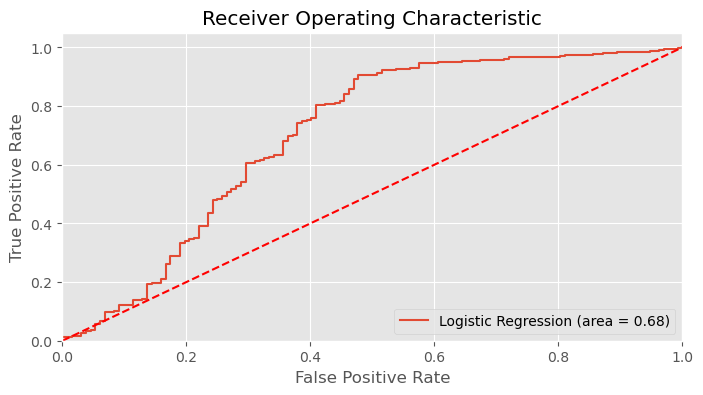

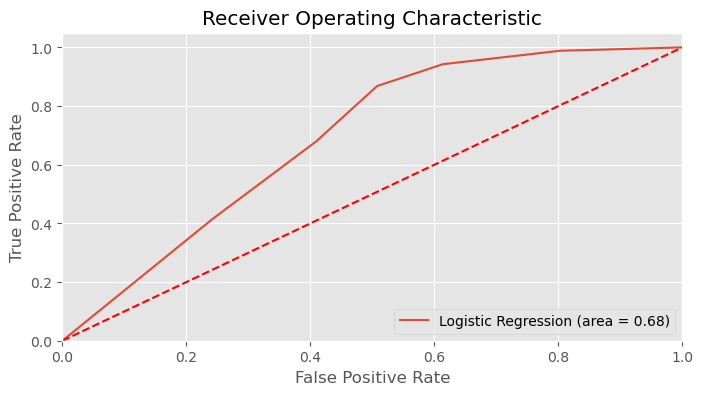

In [115]:
# Logistic Regression
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
plot_roc(false_positive_rate, true_positive_rate)

# KNN
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:,1])
plot_roc(false_positive_rate, true_positive_rate)

The dotted line represents the ROC curve of a purely random classifier.
A good classifier stays as far away from that line as possible to the left top corner.

<a id='Best Model'></a>
## Best Model Analysis

In [116]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Hyperparameter grids for tuning
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'Gradient Boosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
}

# Train, tune, and evaluate models
results = []
for model_name, model in models.items():
    grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    results.append({
        'Model': model_name,
        'Best Params': grid.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Display model evaluation results
results_df = pd.DataFrame(results)

KeyboardInterrupt: 

## Conclusion
In this notebook, we explored logistic regression model to predict whether the short straddle strategy would generate positive returns after holding for 3 days or not. You can implement the same code on different options strategies to predict whether the strategy would be profitable or not over the holding period.